# __Chess Games History Analysis__

In [1]:
# Main Libraries
import chess.pgn
import pandas as pd
import chess.pgn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
# Set style for better plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Path to PGN file
pgn_file = "lichess_Hazem74.pgn"

In [3]:
# Parse the PGN file
games = []
games_data = []
all_headers = set()
with open(pgn_file, encoding="utf-8") as f:
    while True:
        game = chess.pgn.read_game(f)
        if game is None:
            break
        games.append(game)
        games_data.append(game.headers)
        all_headers.update(game.headers.keys())

print(f"Loaded {len(games)} games")

Loaded 1295 games


In [4]:
# Headers
print("All available PGN headers:")
for h in sorted(all_headers):
    print(h)

All available PGN headers:
Annotator
Black
BlackElo
BlackRatingDiff
Date
ECO
Event
GameId
Opening
Result
Round
Site
Termination
TimeControl
UTCDate
UTCTime
Variant
White
WhiteElo
WhiteRatingDiff


In [5]:
games[0].headers

Headers(Event='casual rapid game', Site='https://lichess.org/kJaN4Ovd', Date='2025.09.04', Round='?', White='Hazem74', Black='Zivkostevanovic', Result='0-1', GameId='kJaN4Ovd', UTCDate='2025.09.04', UTCTime='22:14:23', WhiteElo='1814', BlackElo='1998', Variant='Standard', TimeControl='600+0', ECO='B10', Opening='Caro-Kann Defense: Accelerated Panov Attack', Termination='Time forfeit', Annotator='lichess.org')

In [6]:
# Convert to DataFrame
df = pd.DataFrame([{h: g.get(h, None) for h in all_headers} for g in games_data])

# Data cleaning and feature engineering
df['Date'] = pd.to_datetime(df['UTCDate'], errors='coerce')
df['WhiteElo'] = pd.to_numeric(df['WhiteElo'], errors='coerce')
df['BlackElo'] = pd.to_numeric(df['BlackElo'], errors='coerce')

# Determine if you played as White or Black
your_username = 'Hazem74'
df['YourColor'] = df.apply(lambda x: 'White' if x['White'] == your_username else 'Black', axis=1)
df['YourElo'] = df.apply(lambda x: x['WhiteElo'] if x['White'] == your_username else x['BlackElo'], axis=1)
df['OpponentElo'] = df.apply(lambda x: x['BlackElo'] if x['White'] == your_username else x['WhiteElo'], axis=1)
df['Opponent'] = df.apply(lambda x: x['Black'] if x['White'] == your_username else x['White'], axis=1)

# Determine win/loss/draw
def determine_result(row):
    if row['Result'] == '1/2-1/2':
        return 'Draw'
    elif (row['Result'] == '1-0' and row['YourColor'] == 'White') or \
         (row['Result'] == '0-1' and row['YourColor'] == 'Black'):
        return 'Win'
    else:
        return 'Loss'

df['YourResult'] = df.apply(determine_result, axis=1)

# Rating difference
df['EloDiff'] = df['YourElo'] - df['OpponentElo']

# Extract time control category
def categorize_time_control(tc):
    if pd.isna(tc):
        return 'Unknown'
    if '+' in str(tc):
        base = int(tc.split('+')[0])
        if base < 180:
            return 'Bullet'
        elif base < 480:
            return 'Blitz'
        elif base < 1500:
            return 'Rapid'
        else:
            return 'Classical'
    return 'Unknown'

df['TimeCategory'] = df['TimeControl'].apply(categorize_time_control)

# Extract opening family (first part before colon)
df['OpeningFamily'] = df['Opening'].str.split(':').str[0]

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

print(f"✓ DataFrame created with {len(df)} games")
print(f"\nDate range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nColumns: {list(df.columns)}")
df.head()

✓ DataFrame created with 1295 games

Date range: 2022-07-27 00:00:00 to 2025-09-04 00:00:00

Columns: ['Annotator', 'Event', 'Black', 'Site', 'Variant', 'GameId', 'Termination', 'UTCTime', 'UTCDate', 'Date', 'White', 'WhiteRatingDiff', 'Round', 'ECO', 'WhiteElo', 'BlackRatingDiff', 'BlackElo', 'Result', 'Opening', 'TimeControl', 'YourColor', 'YourElo', 'OpponentElo', 'Opponent', 'YourResult', 'EloDiff', 'TimeCategory', 'OpeningFamily']


,Annotator,Event,Black,Site,Variant,GameId,Termination,UTCTime,UTCDate,Date,...,Opening,TimeControl,YourColor,YourElo,OpponentElo,Opponent,YourResult,EloDiff,TimeCategory,OpeningFamily
0,lichess.org,casual rapid game,Hazem74,https://lichess.org/jXjUNFbL,Standard,jXjUNFbL,Normal,13:03:59,2022.07.27,2022-07-27,...,Van't Kruijs Opening,600+0,Black,1500.0,NaN,Anonymous,Win,NaN,Rapid,Van't Kruijs Opening
1,lichess.org,casual blitz game,Hazem74,https://lichess.org/dhLaeOdQ,Standard,dhLaeOdQ,Normal,13:45:05,2022.07.28,2022-07-28,...,Queen's Pawn Game: Accelerated London System,300+3,Black,1500.0,1567.0,Volas1111111,Loss,-67.0,Blitz,Queen's Pawn Game
2,lichess.org,casual blitz game,Owarid4,https://lichess.org/LftXbG8A,Standard,LftXbG8A,Normal,13:43:15,2022.07.28,2022-07-28,...,Indian Defense,300+3,White,1500.0,1509.0,Owarid4,Loss,-9.0,Blitz,Indian Defense
3,lichess.org,casual blitz game,AntonioGaudi,https://lichess.org/qgTmEY44,Standard,qgTmEY44,Normal,11:02:11,2022.07.28,2022-07-28,...,Queen's Pawn Game: Accelerated London System,300+3,White,1500.0,1570.0,AntonioGaudi,Loss,-70.0,Blitz,Queen's Pawn Game
4,lichess.org,casual blitz game,tstastny,https://lichess.org/3b2tnscr,Standard,3b2tnscr,Normal,11:16:33,2022.07.28,2022-07-28,...,Queen's Pawn Game: Accelerated London System,300+3,White,1500.0,1500.0,tstastny,Win,0.0,Blitz,Queen's Pawn Game


In [7]:
print("=" * 70)
print("OVERALL STATISTICS")
print("=" * 70)

total_games = len(df)
wins = len(df[df['YourResult'] == 'Win'])
losses = len(df[df['YourResult'] == 'Loss'])
draws = len(df[df['YourResult'] == 'Draw'])

print(f"\nTotal Games: {total_games}")
print(f"Wins: {wins} ({wins/total_games*100:.1f}%)")
print(f"Losses: {losses} ({losses/total_games*100:.1f}%)")
print(f"Draws: {draws} ({draws/total_games*100:.1f}%)")
print(f"\nWin Rate: {wins/(total_games-draws)*100:.1f}% (excluding draws)")

print(f"\n" + "-" * 70)
print("PERFORMANCE BY COLOR")
print("-" * 70)

for color in ['White', 'Black']:
    color_df = df[df['YourColor'] == color]
    color_wins = len(color_df[color_df['YourResult'] == 'Win'])
    color_total = len(color_df)
    color_draws = len(color_df[color_df['YourResult'] == 'Draw'])
    print(f"\n{color}:")
    print(f"  Games: {color_total}")
    print(f"  Wins: {color_wins} ({color_wins/color_total*100:.1f}%)")
    print(f"  Win Rate: {color_wins/(color_total-color_draws)*100:.1f}% (excluding draws)")

print(f"\n" + "-" * 70)
print("PERFORMANCE BY TIME CONTROL")
print("-" * 70)

for tc in df['TimeCategory'].value_counts().index:
    tc_df = df[df['TimeCategory'] == tc]
    tc_wins = len(tc_df[tc_df['YourResult'] == 'Win'])
    tc_total = len(tc_df)
    print(f"\n{tc}: {tc_total} games, {tc_wins} wins ({tc_wins/tc_total*100:.1f}%)")

OVERALL STATISTICS

Total Games: 1295
Wins: 586 (45.3%)
Losses: 659 (50.9%)
Draws: 50 (3.9%)

Win Rate: 47.1% (excluding draws)

----------------------------------------------------------------------
PERFORMANCE BY COLOR
----------------------------------------------------------------------

White:
  Games: 645
  Wins: 296 (45.9%)
  Win Rate: 47.7% (excluding draws)

Black:
  Games: 650
  Wins: 290 (44.6%)
  Win Rate: 46.5% (excluding draws)

----------------------------------------------------------------------
PERFORMANCE BY TIME CONTROL
----------------------------------------------------------------------

Blitz: 1003 games, 443 wins (44.2%)

Rapid: 291 games, 143 wins (49.1%)

Bullet: 1 games, 0 wins (0.0%)


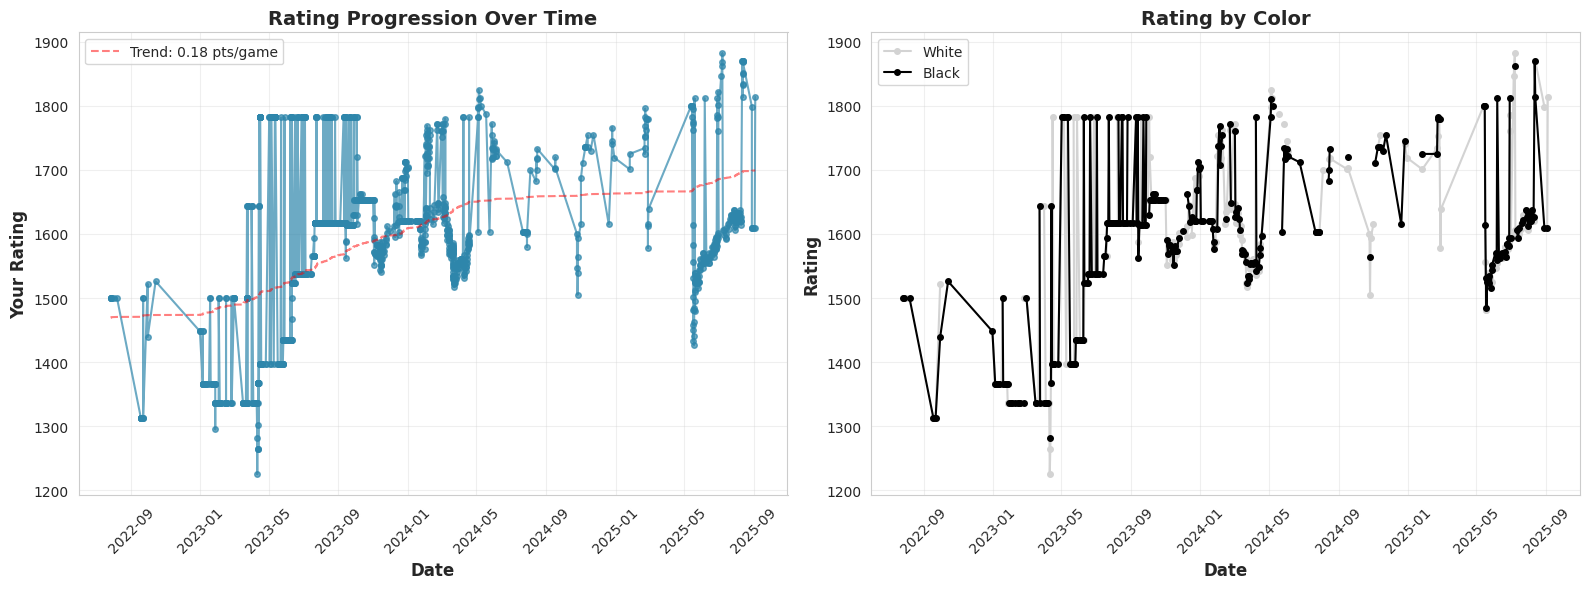

In [8]:
# Rating progression
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Your rating over time
ax1.plot(df['Date'], df['YourElo'], marker='o', linestyle='-', markersize=4, alpha=0.7, color='#2E86AB')
ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
ax1.set_ylabel('Your Rating', fontsize=12, fontweight='bold')
ax1.set_title('Rating Progression Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Add trend line
z = np.polyfit(range(len(df)), df['YourElo'].dropna(), 1)
p = np.poly1d(z)
ax1.plot(df['Date'], p(range(len(df))), "r--", alpha=0.5, label=f'Trend: {z[0]:.2f} pts/game')
ax1.legend()

# Plot 2: Rating by color
color_ratings = df.groupby(['Date', 'YourColor'])['YourElo'].first().unstack()
if 'White' in color_ratings.columns:
    ax2.plot(color_ratings.index, color_ratings['White'], marker='o', label='White', color='lightgray', markersize=4)
if 'Black' in color_ratings.columns:
    ax2.plot(color_ratings.index, color_ratings['Black'], marker='o', label='Black', color='black', markersize=4)
ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Rating', fontsize=12, fontweight='bold')
ax2.set_title('Rating by Color', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [9]:
# Rating statistics
print(f"Current Rating: {df['YourElo'].iloc[-1]:.0f}")
print(f"Peak Rating: {df['YourElo'].max():.0f}")
print(f"Lowest Rating: {df['YourElo'].min():.0f}")
print(f"Rating Range: {df['YourElo'].max() - df['YourElo'].min():.0f} points")

Current Rating: 1814
Peak Rating: 1882
Lowest Rating: 1225
Rating Range: 657 points


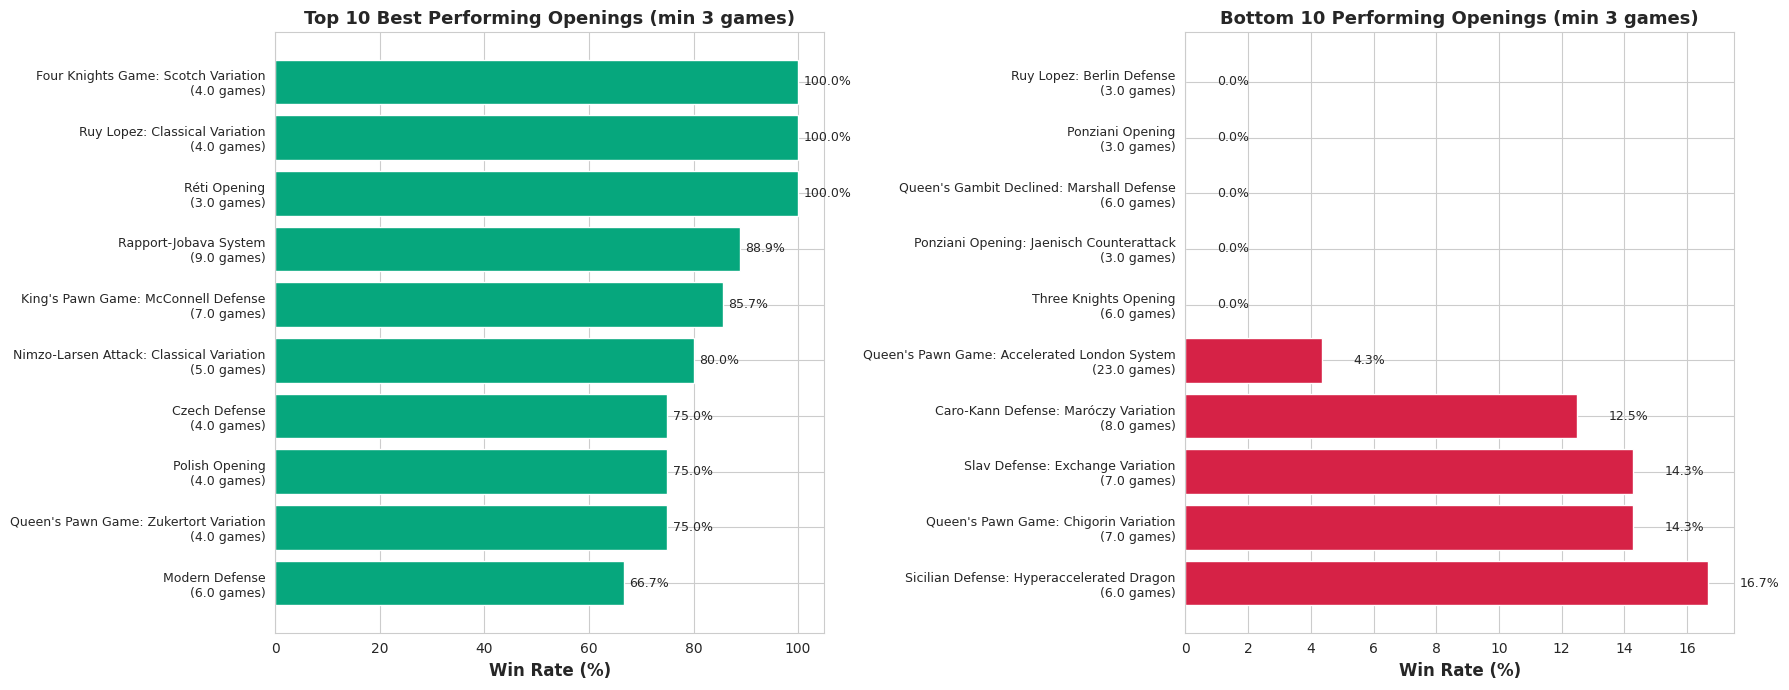

In [10]:
# Calculate win rates for openings with at least 3 games
opening_stats = df.groupby('Opening').agg({
    'YourResult': lambda x: (x == 'Win').sum() / len(x) * 100,
    'Opening': 'count'
}).rename(columns={'YourResult': 'WinRate', 'Opening': 'Count'})

# Filter openings with at least 3 games
opening_stats = opening_stats[opening_stats['Count'] >= 3].sort_values('WinRate', ascending=False)

# Top 10 best performing openings
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Best openings
best_openings = opening_stats.head(10)
ax1.barh(range(len(best_openings)), best_openings['WinRate'], color='#06A77D')
ax1.set_yticks(range(len(best_openings)))
ax1.set_yticklabels([f"{idx}\n({row['Count']} games)" for idx, row in best_openings.iterrows()], fontsize=9)
ax1.set_xlabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 Best Performing Openings (min 3 games)', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
for i, v in enumerate(best_openings['WinRate']):
    ax1.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=9)

# Worst openings
worst_openings = opening_stats.tail(10).sort_values('WinRate', ascending=True)
ax2.barh(range(len(worst_openings)), worst_openings['WinRate'], color='#D62246')
ax2.set_yticks(range(len(worst_openings)))
ax2.set_yticklabels([f"{idx}\n({row['Count']} games)" for idx, row in worst_openings.iterrows()], fontsize=9)
ax2.set_xlabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Bottom 10 Performing Openings (min 3 games)', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
for i, v in enumerate(worst_openings['WinRate']):
    ax2.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

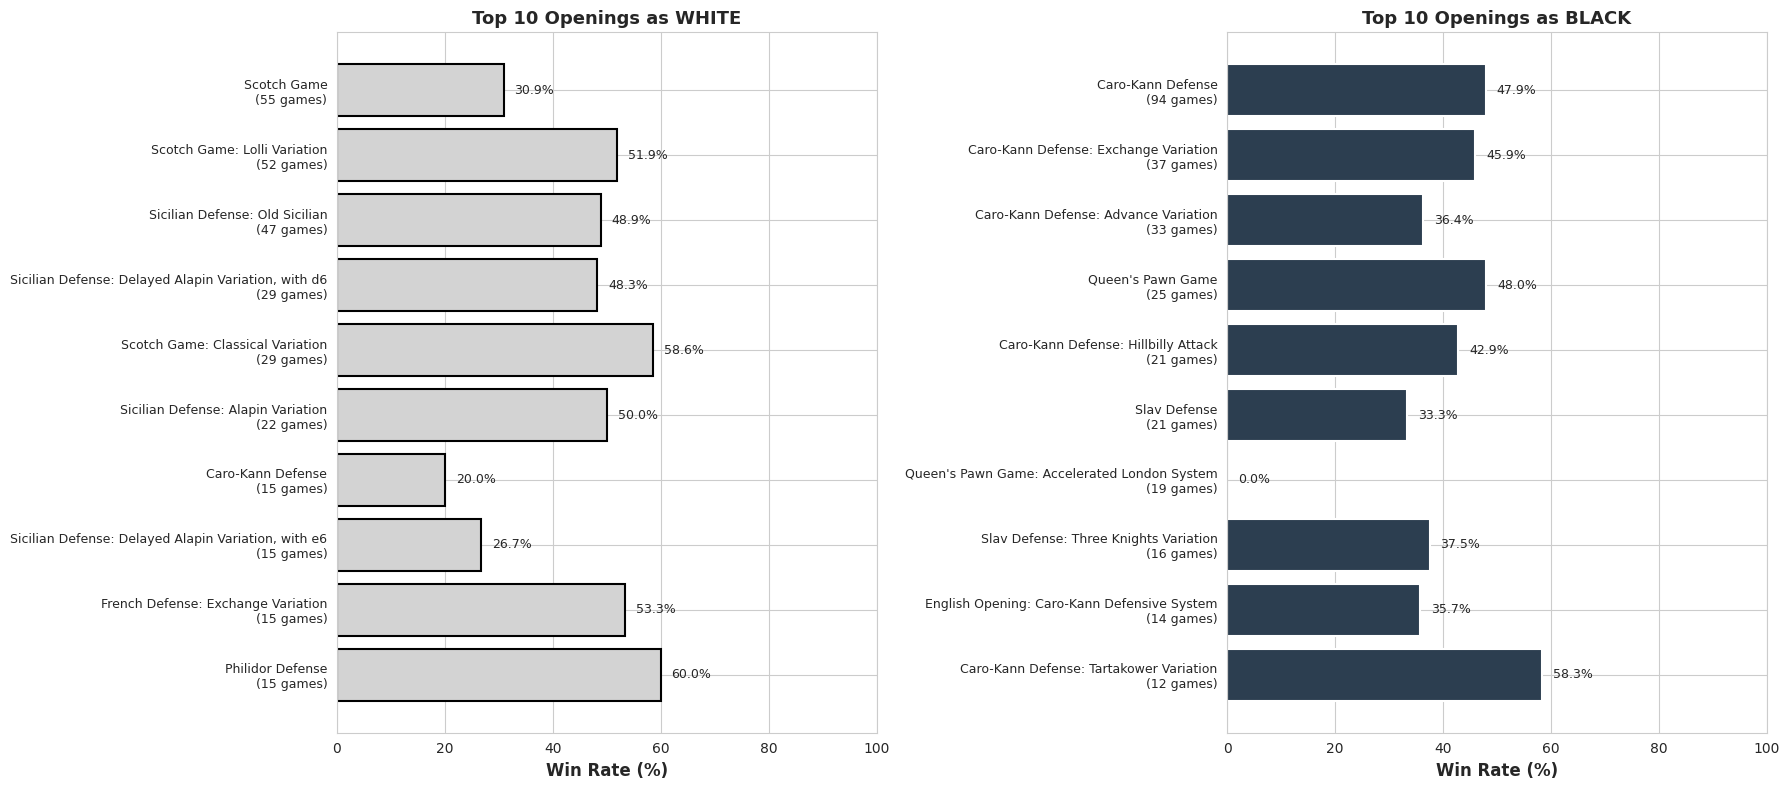

In [11]:
# Opening performance split by color
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# White openings
white_df = df[df['YourColor'] == 'White']
white_openings = white_df['Opening'].value_counts().head(10)
white_win_rates = []
for opening in white_openings.index:
    games = white_df[white_df['Opening'] == opening]
    win_rate = (games['YourResult'] == 'Win').sum() / len(games) * 100
    white_win_rates.append(win_rate)

bars1 = ax1.barh(range(len(white_openings)), white_win_rates, color='lightgray', edgecolor='black', linewidth=1.5)
ax1.set_yticks(range(len(white_openings)))
ax1.set_yticklabels([f"{op}\n({white_openings[op]} games)" for op in white_openings.index], fontsize=9)
ax1.set_xlabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Top 10 Openings as WHITE', fontsize=13, fontweight='bold')
ax1.invert_yaxis()
ax1.set_xlim(0, 100)
for i, v in enumerate(white_win_rates):
    ax1.text(v + 2, i, f'{v:.1f}%', va='center', fontsize=9)

# Black openings
black_df = df[df['YourColor'] == 'Black']
black_openings = black_df['Opening'].value_counts().head(10)
black_win_rates = []
for opening in black_openings.index:
    games = black_df[black_df['Opening'] == opening]
    win_rate = (games['YourResult'] == 'Win').sum() / len(games) * 100
    black_win_rates.append(win_rate)

bars2 = ax2.barh(range(len(black_openings)), black_win_rates, color='#2C3E50', edgecolor='white', linewidth=1.5)
ax2.set_yticks(range(len(black_openings)))
ax2.set_yticklabels([f"{op}\n({black_openings[op]} games)" for op in black_openings.index], fontsize=9)
ax2.set_xlabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Top 10 Openings as BLACK', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
ax2.set_xlim(0, 100)
for i, v in enumerate(black_win_rates):
    ax2.text(v + 2, i, f'{v:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

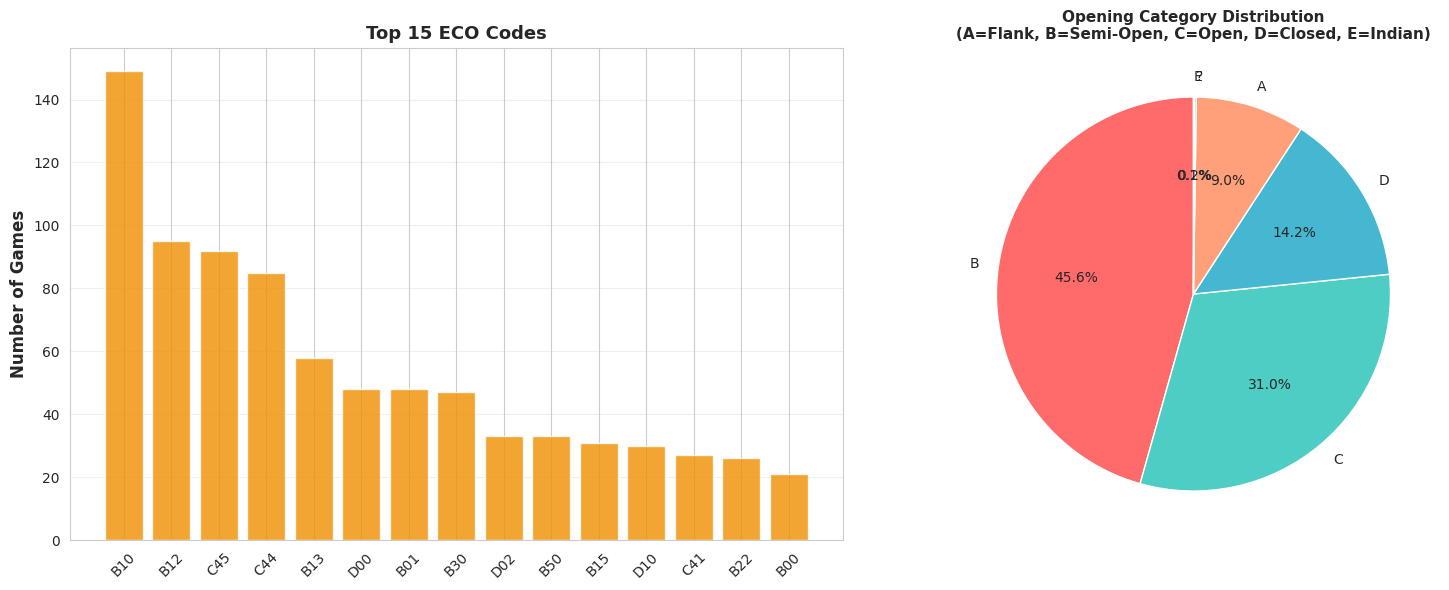


ECO Categories:
A: Flank Openings
B: Semi-Open Games
C: Open Games
D: Closed Games
E: Indian Defenses

ECO_Category
B    591
C    401
D    184
A    116
?      2
E      1
Name: count, dtype: int64


In [12]:
# ECO code distribution
eco_counts = df['ECO'].value_counts().head(15)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ECO distribution
ax1.bar(range(len(eco_counts)), eco_counts.values, color='#F18F01', alpha=0.8)
ax1.set_xticks(range(len(eco_counts)))
ax1.set_xticklabels(eco_counts.index, rotation=45)
ax1.set_ylabel('Number of Games', fontsize=12, fontweight='bold')
ax1.set_title('Top 15 ECO Codes', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# ECO first letter (opening category)
df['ECO_Category'] = df['ECO'].str[0]
eco_category = df['ECO_Category'].value_counts()
colors_eco = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
ax2.pie(eco_category.values, labels=eco_category.index, autopct='%1.1f%%', 
        colors=colors_eco, startangle=90)
ax2.set_title('Opening Category Distribution\n(A=Flank, B=Semi-Open, C=Open, D=Closed, E=Indian)', 
              fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nECO Categories:")
print("A: Flank Openings")
print("B: Semi-Open Games")
print("C: Open Games")
print("D: Closed Games")
print("E: Indian Defenses")
print(f"\n{eco_category}")

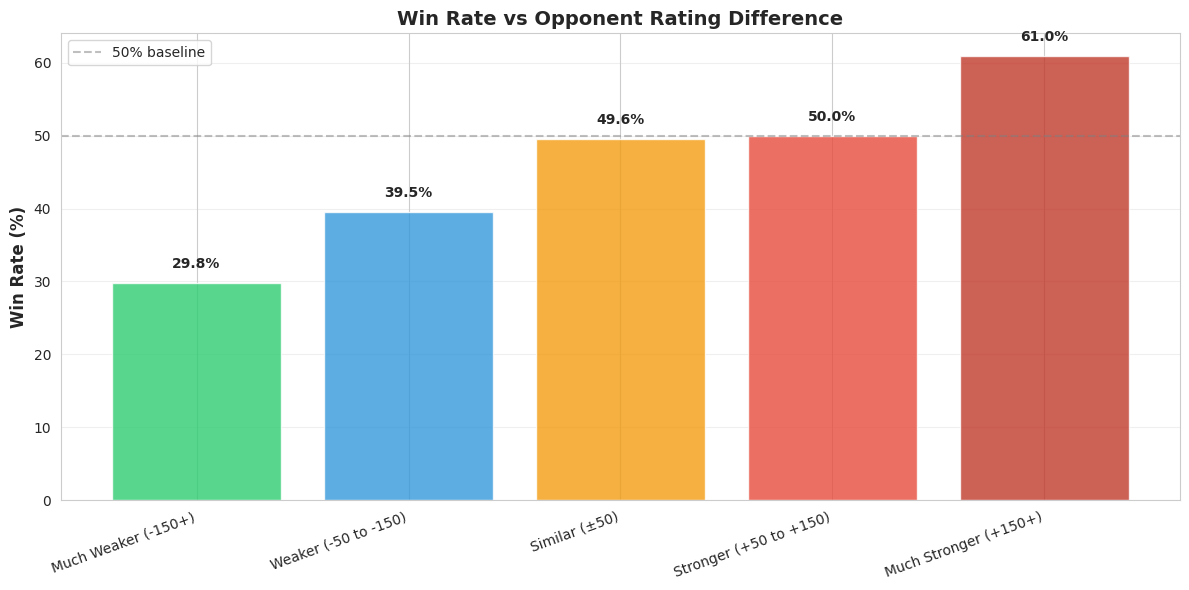


Performance by Rating Difference:
Much Weaker (-150+): 29.8% win rate (171 games)
Weaker (-50 to -150): 39.5% win rate (306 games)
Similar (±50): 49.6% win rate (623 games)
Stronger (+50 to +150): 50.0% win rate (140 games)
Much Stronger (+150+): 61.0% win rate (41 games)


In [13]:
# Performance based on rating difference
df['EloDiffBucket'] = pd.cut(df['EloDiff'], bins=[-500, -150, -50, 50, 150, 500], 
                               labels=['Much Weaker (-150+)', 'Weaker (-50 to -150)', 
                                       'Similar (±50)', 'Stronger (+50 to +150)', 
                                       'Much Stronger (+150+)'])

elo_performance = df.groupby('EloDiffBucket')['YourResult'].apply(
    lambda x: (x == 'Win').sum() / len(x) * 100
).reindex(['Much Weaker (-150+)', 'Weaker (-50 to -150)', 'Similar (±50)', 
           'Stronger (+50 to +150)', 'Much Stronger (+150+)'])

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(len(elo_performance)), elo_performance.values, 
              color=['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#c0392b'], alpha=0.8)
ax.set_xticks(range(len(elo_performance)))
ax.set_xticklabels(elo_performance.index, rotation=20, ha='right')
ax.set_ylabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Win Rate vs Opponent Rating Difference', fontsize=14, fontweight='bold')
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50% baseline')
ax.grid(axis='y', alpha=0.3)
ax.legend()

for i, v in enumerate(elo_performance.values):
    ax.text(i, v + 2, f'{v:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print("\nPerformance by Rating Difference:")
for bucket, rate in elo_performance.items():
    count = len(df[df['EloDiffBucket'] == bucket])
    print(f"{bucket}: {rate:.1f}% win rate ({count} games)")

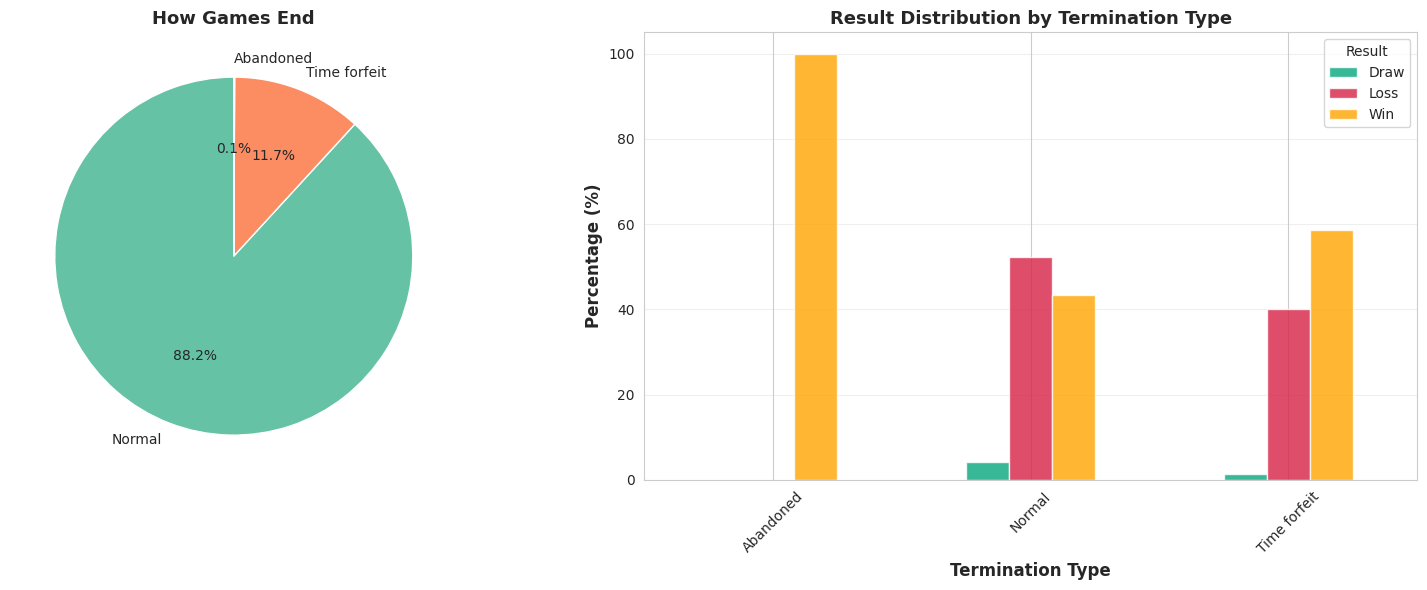

In [14]:
# How games end
termination_counts = df['Termination'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Overall terminations
ax1.pie(termination_counts.values, labels=termination_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette("Set2", len(termination_counts)))
ax1.set_title('How Games End', fontsize=13, fontweight='bold')

# Termination by result
termination_result = pd.crosstab(df['Termination'], df['YourResult'], normalize='index') * 100
termination_result.plot(kind='bar', ax=ax2, color=['#06A77D', '#D62246', '#FFA500'], alpha=0.8)
ax2.set_xlabel('Termination Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax2.set_title('Result Distribution by Termination Type', fontsize=13, fontweight='bold')
ax2.legend(title='Result')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
print("=" * 70)
print("MACHINE LEARNING: GAME OUTCOME PREDICTION")
print("=" * 70)

# Create ML dataset
ml_df = df.copy()

# Remove games with missing values
ml_df = ml_df.dropna(subset=['YourElo', 'OpponentElo', 'ECO', 'Opening', 'TimeCategory', 'YourColor'])

# Encode categorical variables
le_color = LabelEncoder()
le_eco = LabelEncoder()
le_time = LabelEncoder()
le_opening = LabelEncoder()
le_termination = LabelEncoder()

ml_df['Color_Encoded'] = le_color.fit_transform(ml_df['YourColor'])
ml_df['ECO_Encoded'] = le_eco.fit_transform(ml_df['ECO'])
ml_df['TimeCategory_Encoded'] = le_time.fit_transform(ml_df['TimeCategory'])
ml_df['Opening_Encoded'] = le_opening.fit_transform(ml_df['Opening'])

# Target variable: Win = 1, Loss/Draw = 0
ml_df['Won'] = (ml_df['YourResult'] == 'Win').astype(int)

# Features for the model
features = ['YourElo', 'OpponentElo', 'EloDiff', 'Color_Encoded', 
            'ECO_Encoded', 'TimeCategory_Encoded', 'Opening_Encoded']

X = ml_df[features]
y = ml_df['Won']

print(f"\nDataset: {len(ml_df)} games")
print(f"Features: {features}")
print(f"Target distribution:")
print(f"  Wins: {y.sum()} ({y.sum()/len(y)*100:.1f}%)")
print(f"  Losses/Draws: {len(y) - y.sum()} ({(len(y) - y.sum())/len(y)*100:.1f}%)")

MACHINE LEARNING: GAME OUTCOME PREDICTION

Dataset: 1288 games
Features: ['YourElo', 'OpponentElo', 'EloDiff', 'Color_Encoded', 'ECO_Encoded', 'TimeCategory_Encoded', 'Opening_Encoded']
Target distribution:
  Wins: 581 (45.1%)
  Losses/Draws: 707 (54.9%)



RANDOM FOREST CLASSIFIER

Accuracy: 54.04%

Classification Report:
              precision    recall  f1-score   support

   Loss/Draw       0.58      0.61      0.59       177
         Win       0.49      0.46      0.47       145

    accuracy                           0.54       322
   macro avg       0.53      0.53      0.53       322
weighted avg       0.54      0.54      0.54       322



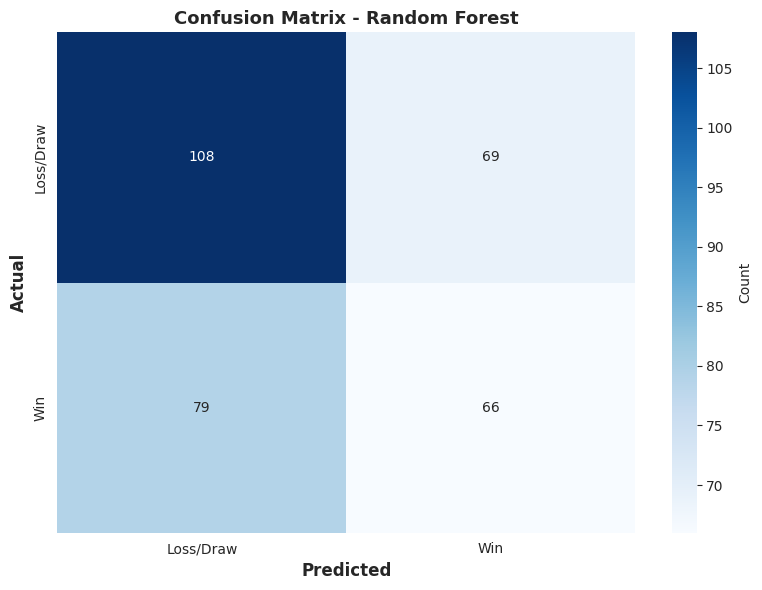

In [16]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("\n" + "=" * 70)
print("RANDOM FOREST CLASSIFIER")
print("=" * 70)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, 
                                   min_samples_split=5, min_samples_leaf=2)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_rf)*100:.2f}%")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Loss/Draw', 'Win']))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Loss/Draw', 'Win'], 
            yticklabels=['Loss/Draw', 'Win'], ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Random Forest', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


Feature Importance:
                Feature  Importance
2               EloDiff    0.245109
1           OpponentElo    0.218252
6       Opening_Encoded    0.167635
0               YourElo    0.163055
4           ECO_Encoded    0.162353
3         Color_Encoded    0.027403
5  TimeCategory_Encoded    0.016193


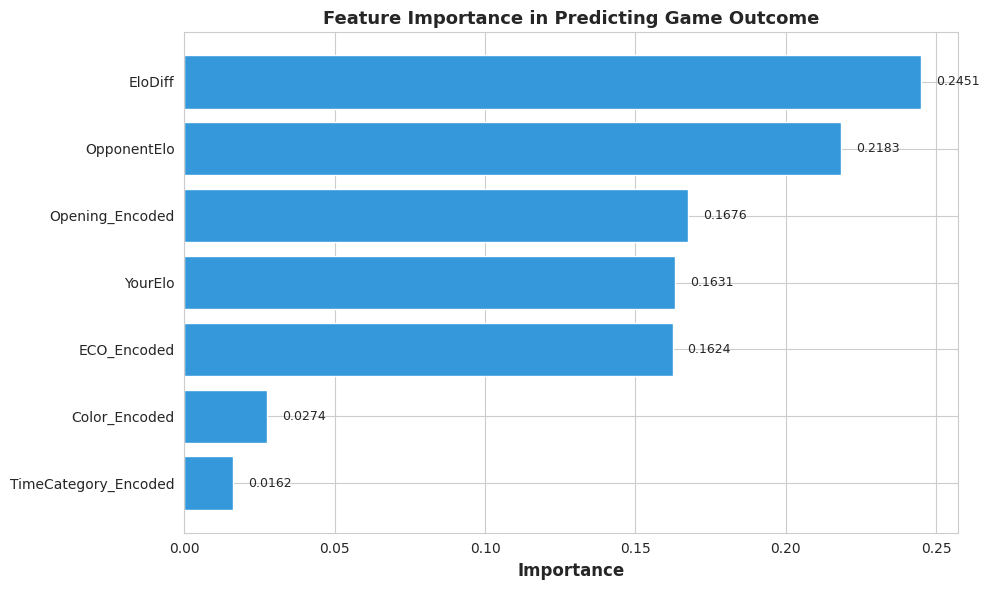


 Key Insights:
- Most important factor: EloDiff
- Rating difference (EloDiff) importance: 0.2451
- Color importance: 0.0274


In [17]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(range(len(feature_importance)), feature_importance['Importance'], color='#3498db')
ax.set_yticks(range(len(feature_importance)))
ax.set_yticklabels(feature_importance['Feature'])
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance in Predicting Game Outcome', fontsize=13, fontweight='bold')
ax.invert_yaxis()

for i, v in enumerate(feature_importance['Importance']):
    ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n Key Insights:")
print(f"- Most important factor: {feature_importance.iloc[0]['Feature']}")
print(f"- Rating difference (EloDiff) importance: {feature_importance[feature_importance['Feature']=='EloDiff']['Importance'].values[0]:.4f}")
print(f"- Color importance: {feature_importance[feature_importance['Feature']=='Color_Encoded']['Importance'].values[0]:.4f}")


GRADIENT BOOSTING CLASSIFIER

Accuracy: 50.93%

Classification Report:
              precision    recall  f1-score   support

   Loss/Draw       0.55      0.55      0.55       177
         Win       0.46      0.46      0.46       145

    accuracy                           0.51       322
   macro avg       0.50      0.50      0.50       322
weighted avg       0.51      0.51      0.51       322



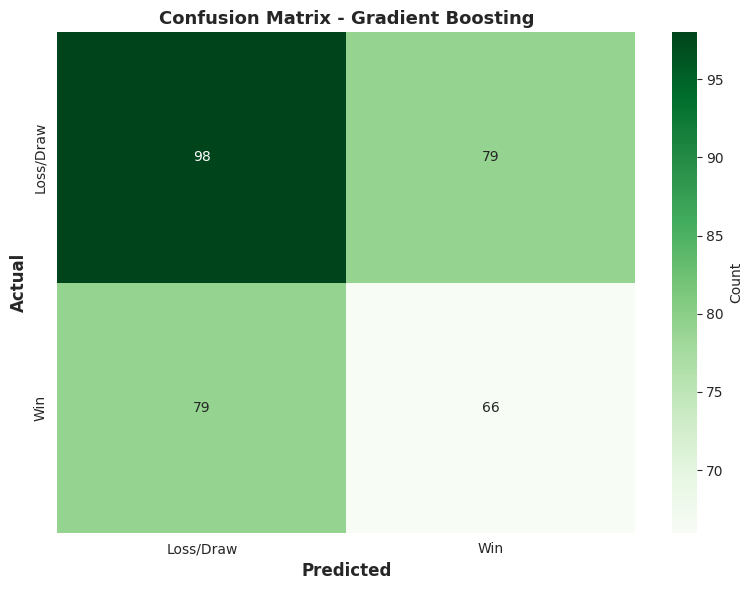

In [18]:
print("\n" + "=" * 70)
print("GRADIENT BOOSTING CLASSIFIER")
print("=" * 70)

# Train Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42, 
                                       learning_rate=0.1, min_samples_split=5)
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Evaluation
print(f"\nAccuracy: {accuracy_score(y_test, y_pred_gb)*100:.2f}%")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=['Loss/Draw', 'Win']))

# Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', xticklabels=['Loss/Draw', 'Win'], 
            yticklabels=['Loss/Draw', 'Win'], ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Gradient Boosting', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


MODEL COMPARISON
               Model  Accuracy  Precision (Win)  Recall (Win)
0      Random Forest  0.540373         0.488889      0.455172
1  Gradient Boosting  0.509317         0.455172      0.455172


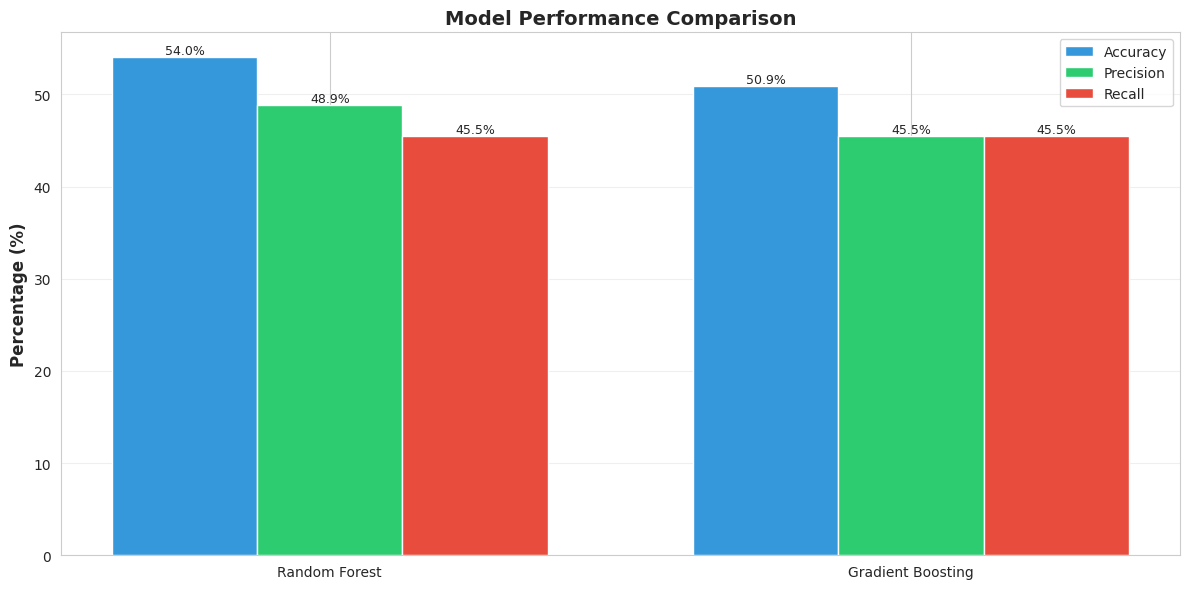

In [19]:
# Compare models
models_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting'],
    'Accuracy': [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_gb)],
    'Precision (Win)': [
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_gb, output_dict=True)['1']['precision']
    ],
    'Recall (Win)': [
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_gb, output_dict=True)['1']['recall']
    ]
})

print("\n" + "=" * 70)
print("MODEL COMPARISON")
print("=" * 70)
print(models_comparison)

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(models_comparison))
width = 0.25

bars1 = ax.bar(x - width, models_comparison['Accuracy']*100, width, label='Accuracy', color='#3498db')
bars2 = ax.bar(x, models_comparison['Precision (Win)']*100, width, label='Precision', color='#2ecc71')
bars3 = ax.bar(x + width, models_comparison['Recall (Win)']*100, width, label='Recall', color='#e74c3c')

ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models_comparison['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


SAMPLE WIN PROBABILITY PREDICTIONS

Showing 10 random predictions from test set:
     Actual  RF_Prediction  GB_Prediction  RF_WinProb  GB_WinProb  YourElo  \
167       1              1              1   73.633843   92.238398   1643.0   
178       0              0              0   29.870657   29.341307   1769.0   
134       1              0              0   23.291138   14.287424   1336.0   
101       1              0              0   43.680574   37.646623   1336.0   
23        1              0              1   47.406616   57.302764   1500.0   
112       0              0              1   44.415804   52.967323   1336.0   
229       0              0              0   29.094706   48.394271   1812.0   
91        0              1              1   51.042575   73.687156   1434.0   
256       1              1              1   66.664248   71.736841   1599.0   
44        0              0              0   25.185910   16.754923   1336.0   

     OpponentElo  EloDiff  
167       1498.0    145.0  
178

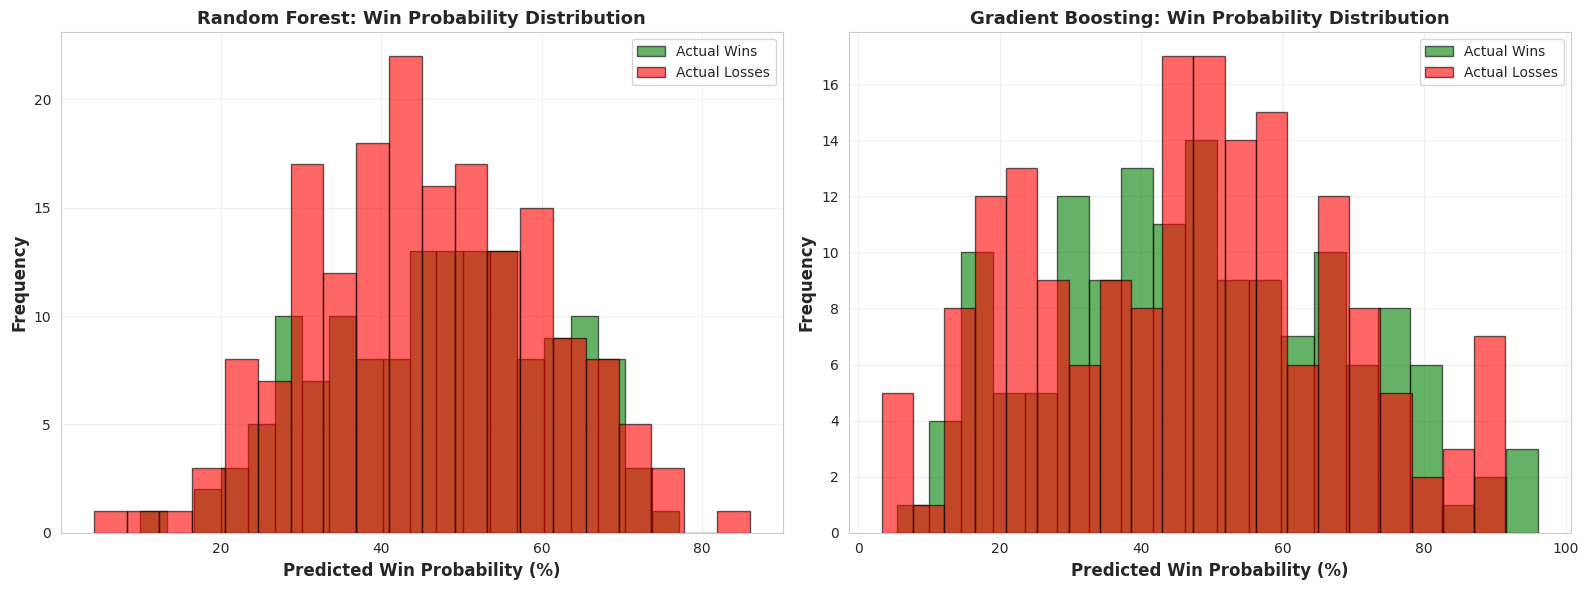

In [20]:
# Predict win probabilities for test set
test_predictions = pd.DataFrame({
    'Actual': y_test.values,
    'RF_Prediction': y_pred_rf,
    'GB_Prediction': y_pred_gb,
    'RF_WinProb': y_pred_proba_rf * 100,
    'GB_WinProb': y_pred_proba_gb * 100,
    'YourElo': X_test['YourElo'].values,
    'OpponentElo': X_test['OpponentElo'].values,
    'EloDiff': X_test['EloDiff'].values
})

print("\n" + "=" * 70)
print("SAMPLE WIN PROBABILITY PREDICTIONS")
print("=" * 70)
print("\nShowing 10 random predictions from test set:")
print(test_predictions.sample(10))

# Plot probability distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest probabilities
ax1.hist(test_predictions[test_predictions['Actual']==1]['RF_WinProb'], 
         bins=20, alpha=0.6, label='Actual Wins', color='green', edgecolor='black')
ax1.hist(test_predictions[test_predictions['Actual']==0]['RF_WinProb'], 
         bins=20, alpha=0.6, label='Actual Losses', color='red', edgecolor='black')
ax1.set_xlabel('Predicted Win Probability (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('Random Forest: Win Probability Distribution', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Gradient Boosting probabilities
ax2.hist(test_predictions[test_predictions['Actual']==1]['GB_WinProb'], 
         bins=20, alpha=0.6, label='Actual Wins', color='green', edgecolor='black')
ax2.hist(test_predictions[test_predictions['Actual']==0]['GB_WinProb'], 
         bins=20, alpha=0.6, label='Actual Losses', color='red', edgecolor='black')
ax2.set_xlabel('Predicted Win Probability (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax2.set_title('Gradient Boosting: Win Probability Distribution', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
def predict_game_outcome(your_elo, opponent_elo, color, eco_code, time_category, opening):
    """
    Predict the outcome of a future game
    
    Parameters:
    - your_elo: Your current rating
    - opponent_elo: Opponent's rating
    - color: 'White' or 'Black'
    - eco_code: ECO code (e.g., 'C45')
    - time_category: 'Bullet', 'Blitz', 'Rapid', or 'Classical'
    - opening: Opening name
    """
    
    # Encode inputs
    try:
        color_enc = le_color.transform([color])[0]
    except:
        color_enc = 0
    
    try:
        eco_enc = le_eco.transform([eco_code])[0]
    except:
        eco_enc = 0
    
    try:
        time_enc = le_time.transform([time_category])[0]
    except:
        time_enc = 0
    
    try:
        opening_enc = le_opening.transform([opening])[0]
    except:
        opening_enc = 0
    
    elo_diff = your_elo - opponent_elo
    
    # Create feature array
    features_input = np.array([[your_elo, opponent_elo, elo_diff, color_enc, 
                                eco_enc, time_enc, opening_enc]])
    
    # Predict with both models
    rf_prob = rf_model.predict_proba(features_input)[0][1] * 100
    gb_prob = gb_model.predict_proba(features_input)[0][1] * 100
    avg_prob = (rf_prob + gb_prob) / 2
    
    print("=" * 70)
    print("GAME OUTCOME PREDICTION")
    print("=" * 70)
    print(f"\nYour Rating: {your_elo}")
    print(f"Opponent Rating: {opponent_elo}")
    print(f"Rating Difference: {elo_diff:+.0f}")
    print(f"Color: {color}")
    print(f"ECO: {eco_code}")
    print(f"Time Control: {time_category}")
    print(f"Opening: {opening}")
    print("\n" + "-" * 70)
    print("PREDICTED WIN PROBABILITIES:")
    print("-" * 70)
    print(f"Random Forest:     {rf_prob:.1f}%")
    print(f"Gradient Boosting: {gb_prob:.1f}%")
    print(f"Average:           {avg_prob:.1f}%")
    print("=" * 70)
    
    return avg_prob

In [22]:
# Example prediction
print("\nExample Prediction:")
predict_game_outcome(
    your_elo=1650,
    opponent_elo=1600,
    color='White',
    eco_code='C45',
    time_category='Blitz',
    opening='Scotch Game'
)


Example Prediction:
GAME OUTCOME PREDICTION

Your Rating: 1650
Opponent Rating: 1600
Rating Difference: +50
Color: White
ECO: C45
Time Control: Blitz
Opening: Scotch Game

----------------------------------------------------------------------
PREDICTED WIN PROBABILITIES:
----------------------------------------------------------------------
Random Forest:     46.4%
Gradient Boosting: 49.7%
Average:           48.0%


np.float64(48.046639021218226)

In [23]:
print("\n" + "=" * 70)
print(" COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 70)

# Overall stats
total = len(df)
wins = len(df[df['YourResult'] == 'Win'])
win_rate = wins / total * 100

# Best and worst openings
best_opening = opening_stats.head(1)
worst_opening = opening_stats.tail(1)

# Rating stats
rating_change = df['YourElo'].iloc[-1] - df['YourElo'].iloc[0]
peak_rating = df['YourElo'].max()

# Color performance
white_wr = len(df[(df['YourColor']=='White') & (df['YourResult']=='Win')]) / len(df[df['YourColor']=='White']) * 100
black_wr = len(df[(df['YourColor']=='Black') & (df['YourResult']=='Win')]) / len(df[df['YourColor']=='Black']) * 100

print(f"\n OVERALL PERFORMANCE:")
print(f"   • Total Games: {total}")
print(f"   • Win Rate: {win_rate:.1f}%")
print(f"   • Current Rating: {df['YourElo'].iloc[-1]:.0f}")
print(f"   • Peak Rating: {peak_rating:.0f}")
print(f"   • Rating Change: {rating_change:+.0f} points")

print(f"\n COLOR PERFORMANCE:")
print(f"   • White Win Rate: {white_wr:.1f}%")
print(f"   • Black Win Rate: {black_wr:.1f}%")
print(f"   • Color Advantage: {abs(white_wr - black_wr):.1f}% ({'White' if white_wr > black_wr else 'Black'})")

print(f"\n OPENING INSIGHTS:")
print(f"   • Most Played: {df['Opening'].value_counts().index[0]} ({df['Opening'].value_counts().values[0]} games)")
if len(best_opening) > 0:
    print(f"   • Best Performing: {best_opening.index[0]} ({best_opening['WinRate'].values[0]:.1f}% WR, {best_opening['Count'].values[0]} games)")
if len(worst_opening) > 0:
    print(f"   • Worst Performing: {worst_opening.index[0]} ({worst_opening['WinRate'].values[0]:.1f}% WR, {worst_opening['Count'].values[0]} games)")

print(f"\n TIME CONTROL:")
most_played_tc = df['TimeCategory'].value_counts().index[0]
print(f"   • Most Played: {most_played_tc} ({df['TimeCategory'].value_counts().values[0]} games)")

print(f"\n MACHINE LEARNING:")
print(f"   • Best Model: {'Random Forest' if accuracy_score(y_test, y_pred_rf) > accuracy_score(y_test, y_pred_gb) else 'Gradient Boosting'}")
print(f"   • Prediction Accuracy: {max(accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_gb))*100:.1f}%")
print(f"   • Key Feature: {feature_importance.iloc[0]['Feature']}")

print("\n" + "=" * 70)


 COMPREHENSIVE ANALYSIS SUMMARY

 OVERALL PERFORMANCE:
   • Total Games: 1295
   • Win Rate: 45.3%
   • Current Rating: 1814
   • Peak Rating: 1882
   • Rating Change: +314 points

 COLOR PERFORMANCE:
   • White Win Rate: 45.9%
   • Black Win Rate: 44.6%
   • Color Advantage: 1.3% (White)

 OPENING INSIGHTS:
   • Most Played: Caro-Kann Defense (109 games)
   • Best Performing: Four Knights Game: Scotch Variation (100.0% WR, 4 games)
   • Worst Performing: Three Knights Opening (0.0% WR, 6 games)

 TIME CONTROL:
   • Most Played: Blitz (1003 games)

 MACHINE LEARNING:
   • Best Model: Random Forest
   • Prediction Accuracy: 54.0%
   • Key Feature: EloDiff

